# Fix the TropiSeq DF results : 

In [2]:
'''# Torch geometric modules
from torch_geometric.data import HeteroData, DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero , HeteroConv , GATv2Conv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

# Torch modules
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# SKlearn modules
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder , label_binarize , OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , matthews_corrcoef
'''
# Ground modules
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import random
from collections import Counter
import warnings
import logging
from multiprocessing.pool import ThreadPool

# TropiGAT modules
#import TropiGAT_graph
#import TropiGAT_models

warnings.filterwarnings("ignore")

In [3]:
# *****************************************************************************
# Load the Dataframes :
path_work = "/media/concha-eloko/Linux/PPT_clean"
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.tsv", sep = "\t" ,  header = 0)

DF_info = DF_info.drop_duplicates(subset = ["Protein_name"])

df_prophages = DF_info.drop_duplicates(subset = ["Phage"], keep = "first")
dico_prophage_info = {row["Phage"] : {"prophage_strain" : row["prophage_id"] , "ancestor" : row["Infected_ancestor"]} for _,row in df_prophages.iterrows()}

def get_filtered_prophages(prophage) :
    combinations = []
    to_exclude = set()
    to_keep = set()
    to_keep.add(prophage)
    df_prophage_group = DF_info[(DF_info["prophage_id"] == dico_prophage_info[prophage]["prophage_strain"]) & (DF_info["Infected_ancestor"] == dico_prophage_info[prophage]["ancestor"])]
    if len(df_prophage_group) == 1 :
        pass
    else :
        depo_set = set(df_prophage_group[df_prophage_group["Phage"] == prophage]["domain_seq"].values)
        for prophage_tmp in df_prophage_group["Phage"].unique().tolist() :
            if prophage_tmp != prophage :
                tmp_depo_set = set(df_prophage_group[df_prophage_group["Phage"] == prophage_tmp]["domain_seq"].values)
                if depo_set == tmp_depo_set :
                    to_exclude.add(prophage_tmp)
                else :
                    if tmp_depo_set not in combinations :
                        to_keep.add(prophage_tmp)
                        combinations.append(tmp_depo_set)
                    else :
                        to_exclude.add(prophage_tmp)
    return df_prophage_group , to_exclude , to_keep

good_prophages = set()
excluded_prophages = set()

for prophage, info_prophage in tqdm(dico_prophage_info.items()) :
    if prophage not in excluded_prophages and prophage not in good_prophages:
        _, excluded_members , kept_members = get_filtered_prophages(prophage)
        good_prophages.update(kept_members)
        excluded_prophages.update(excluded_members)

DF_info_lvl_0_filtered = DF_info[DF_info["Phage"].isin(good_prophages)]
DF_info_lvl_0_final = DF_info_lvl_0_filtered[~DF_info_lvl_0_filtered["KL_type_LCA"].str.contains("\\|")]

DF_info_lvl_0 = DF_info_lvl_0_final.copy()



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 15981/15981 [00:38<00:00, 414.63it/s]


In [9]:
df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))



In [ ]:
dico_prophage_count

In [4]:
import pandas as pd 
import os 

path_seqbased = "/media/concha-eloko/Linux/PPT_clean/RF_2912_models_info"

header_metric = ["KL_type", "Effectifs","MCC","F1","recall","Accuracy","AUC"]
seqbased_df = pd.read_csv(f"{path_seqbased}/RF_report.0.75.0702.tsv", sep = "\t", header = 0)

In [18]:
seqbased_df

,KL_type,n_prophages,MCC,F1,recall,Accuracy,AUC
0,KL41,10,0.000000,0.000000,0.000000,0.833333,0.500000
1,KL30,93,0.390511,0.466667,0.411765,0.857143,0.674303
2,KL6,12,0.000000,0.000000,0.000000,0.800000,0.500000
3,KL19,73,0.747625,0.758621,0.611111,0.924731,0.805556
4,KL25,269,0.824502,0.851485,0.877551,0.953560,0.922352
...,...,...,...,...,...,...,...
84,KL20,18,-0.118345,0.000000,0.000000,0.727273,0.470588
85,KL142,14,-0.108465,0.000000,0.000000,0.777778,0.466667
86,KL58,6,0.000000,0.000000,0.000000,0.750000,0.500000
87,KL124,12,0.534522,0.500000,0.333333,0.866667,0.666667


In [12]:
#seqbased_df["R_effectif"] = seqbased_df["KL_type"].apply(lambda x: dico_prophage_count[x])

In [14]:
#seqbased_df_final = seqbased_df[["KL_type", "R_effectif", "MCC", "F1", "recall", "Accuracy", "AUC"]]
#seqbased_df_final.columns = ["KL_type", "n_prophages", "MCC", "F1", "recall", "Accuracy", "AUC"]
#seqbased_df_final.to_csv(f"/media/concha-eloko/Linux/PPT_clean/RF_2912_models_info/RF_report.0.75.0702.tsv", sep = "\t", header = True, index = False)



***
# Make the plot files : 

***
## The MCC vs KL types :

In [5]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#path_models = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/ensemble_2812"
#path_metrics = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/ensemble_2812_log_files/"

In [6]:
path_metrics = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/ensemble_0702_log_files/"
average_metric_df = pd.read_csv(f"/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/Metric_Report.0702.clean.tsv", sep = "\t", header = 0)


In [22]:
average_metric_df

,KL_type,model_version,n_prophages,precision,recall,Accuracy,F1_score,AUC,MCC
0,KL1,KL1__4,190,0.8232,0.4526,0.8930,0.5772,0.8753,0.5570
1,KL2,KL2__4,351,0.7298,0.8743,0.9133,0.7847,0.9506,0.7457
2,KL3,KL3__5,145,0.6630,0.9857,0.9093,0.7872,0.9853,0.7610
3,KL5,KL5__3,28,0.5400,0.8000,0.8375,0.6271,0.8357,0.5648
4,KL7,KL7__1,37,0.4700,1.0000,0.8286,0.6348,0.9222,0.6124
...,...,...,...,...,...,...,...,...,...
62,KL136,KL136__4,32,0.4767,0.8000,0.8211,0.5937,0.9000,0.5193
63,KL145,KL145__2,29,0.3217,0.9000,0.7125,0.4676,0.8286,0.4162
64,KL149,KL149__2,70,0.5063,0.8857,0.8286,0.6353,0.9273,0.5801
65,KL151,KL151__3,61,0.5488,0.9000,0.8500,0.6734,0.9111,0.6228


In [1]:
15/67

0.22388059701492538

In [7]:
import pandas as pd 
import os 

#path_seqbased = "/media/concha-eloko/Linux/PPT_clean/RF_2912_models_info"
#header_metric = ["KL_type", "Effectifs","MCC","F1","recall","Accuracy","AUC"]
#seqbased_df = pd.read_csv(f"{path_seqbased}/RF_report.0.75.0702.tsv", sep = "\t", header = 0)
#seqbased_df_sorted = seqbased_df.sort_values(by='KL_type', key=lambda x: x.str.split("KL").str[1].astype(int))
#seqbased_df_sorted.reset_index(drop=True, inplace=True)
#seqbased_df_sorted.to_csv(f"/media/concha-eloko/Linux/PPT_clean/RF_2912_models_info/RF_report.0.75.0602.tsv", sep = "\t", header = True, index = False)


seqbased_df_sorted = pd.read_csv(f"/media/concha-eloko/Linux/PPT_clean/Seqbased_model/Seqbased_models.clean.prophages_FULL_metrics.2002.tsv", sep = "\t", header = 0)


In [2]:
seqbased_df_sorted

,KL_type,n_prophages,F1,recall,precision,accuracy,AUC,MCC
0,KL1,190,0.527958,0.378947,0.926140,0.890351,0.685789,0.544448
1,KL2,351,0.834817,0.753441,0.937413,0.950425,0.871621,0.813117
2,KL3,145,0.950204,0.924138,0.979524,0.983908,0.960000,0.941760
3,KL5,28,0.643550,0.546667,0.926667,0.913782,0.766437,0.649714
4,KL7,37,0.767552,0.657143,1.000000,0.941717,0.828571,0.774114
...,...,...,...,...,...,...,...,...
68,KL145,29,0.941818,0.900000,1.000000,0.983333,0.950000,0.937719
69,KL149,70,0.838264,0.746667,0.969231,0.953051,0.870516,0.824209
70,KL151,61,0.881988,0.803846,0.981818,0.964495,0.900284,0.868651
71,KL153,18,0.505397,0.450000,0.640000,0.842857,0.686111,0.438683


***
### Scatter plot :

#### TropiGAT :

In [8]:
data_scatter_tropigat = [(row["n_prophages"], row["MCC"]) for _,row in average_metric_df.iterrows()] 

> Classic scatter plot : 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the list of tuples to a DataFrame for easier plotting
import pandas as pd
df = pd.DataFrame(data_scatter_tropigat, columns=['Number of prophages', 'MCC score'])

# Set Seaborn style (optional)
sns.set(style="whitegrid")

# Create a scatter plot using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.scatterplot(x='Number of prophages', y='MCC score', data=df, marker='o', color='blue')

# Add labels and title
plt.xlabel('Number of prophages')
plt.ylabel('MCC score')
plt.title('Scatter Plot')

# Show the plot
plt.show()

> hexbin plot :

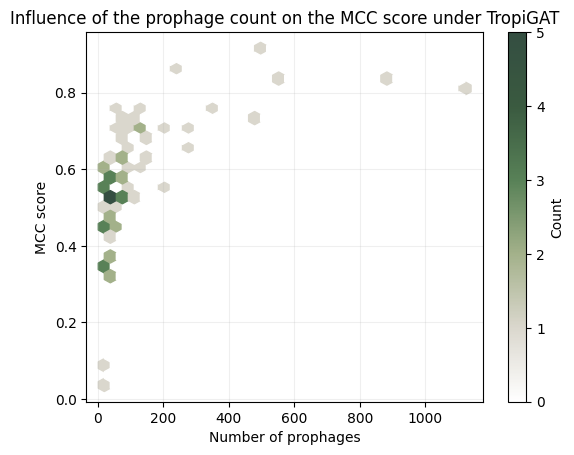

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
df = pd.DataFrame(data_scatter_tropigat, columns=['Number of prophages', 'MCC score'])

#colors = ['#ffffff', '#ffdc73', '#ffbf00', '#bf9b30', '#a67c00', "#423A2A"]
colors = ['#ffffff', '#DAD7CD', '#A3B18A', '#588157', '#3A5A40', '#344E41']

cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

plt.hexbin(df["Number of prophages"], df["MCC score"], gridsize=30, cmap=cmap)

cb = plt.colorbar(label='Count')
plt.grid(True, alpha=0.2)
# Setting labels and title
plt.xlabel('Number of prophages')
plt.ylabel('MCC score')
plt.title('Influence of the prophage count on the MCC score under TropiGAT')
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/scatter_plot.TropiGAT.0702.svg',format = "svg", transparent = True)  # You can change the file extension as needed
# Show the plot
plt.show()

***
#### TropiSeq :

In [9]:
data_scatter_tropiseq = [(row["n_prophages"], row["MCC"]) for _,row in seqbased_df_sorted.iterrows()] 

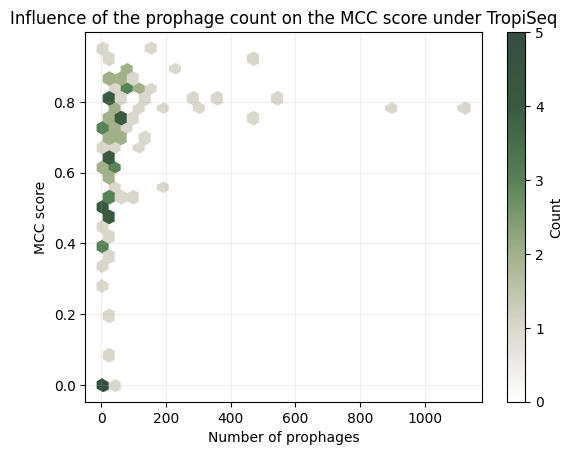

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
df = pd.DataFrame(data_scatter_tropiseq, columns=['Number of prophages', 'MCC score'])

# Define your list of colors
colors = ['#ffffff', '#DAD7CD', '#A3B18A', '#588157', '#3A5A40', '#344E41']

# Create a custom colormap from the specified colors
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Creating the hexbin plot with the custom colormap
plt.hexbin(df["Number of prophages"], df["MCC score"], gridsize=30, cmap=cmap, vmin=0, vmax=5)

# Adding a color bar on the right
cb = plt.colorbar(label='Count')
cb.set_ticks(np.arange(0, 6, 1))  # Set ticks from 0 to 5
cb.set_ticklabels(np.arange(0, 6, 1))  # Set tick labels from 0 to 5

plt.grid(True, alpha=0.2)

# Setting labels and title
plt.xlabel('Number of prophages')
plt.ylabel('MCC score')
plt.title('Influence of the prophage count on the MCC score under TropiSeq')

plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/scatter_plot.TropiSeq.2002.svg', format="svg", transparent=True)

# Show the plot
plt.show()

***
### Pearson correlation number prophages and MCC :

In [1]:
from scipy.stats import pearsonr

def compute_correlation(data):
    """
    Compute the Pearson correlation coefficient between two variables in a list of tuples.
    Parameters:
        data (list of tuples): List of tuples containing pairs of variables.
    Returns:
        correlation_coefficient (float): Pearson correlation coefficient.
    """
    # Unpack the tuples into separate lists for each variable
    var1 = [pair[0] for pair in data]
    var2 = [pair[1] for pair in data]
    # Compute the Pearson correlation coefficient
    correlation_coefficient, pvalue = pearsonr(var1, var2)
    
    return correlation_coefficient, pvalue



In [10]:
#correlation_coefficient_tropigat = compute_correlation(data_scatter_tropigat)
correlation_coefficient_tropiseq, pvalue = compute_correlation(data_scatter_tropiseq)
correlation_coefficient_tropiseq, pvalue

(0.3014755961722197, 0.001970529718584012)

In [11]:
#correlation_coefficient_tropigat = compute_correlation(data_scatter_tropigat)
correlation_coefficient_tropigat, pvalue = compute_correlation(data_scatter_tropigat)
correlation_coefficient_tropigat, pvalue

(0.5709525928509166, 4.533265170417242e-07)

In [ ]:
correlation_coefficient_tropigat , correlation_coefficient_tropiseq

***
### Chord plot : 

In [ ]:
import holoviews as hv
from holoviews import opts
import pandas as pd
import numpy as np
hv.extension('bokeh')

# Sample matrix representing the export volumes between 5 countries
export_data = np.array([[0, 50, 30, 20, 10],   
                        [10, 0, 40, 30, 20],   
                        [20, 10, 0, 35, 25],   
                        [30, 20, 10, 0, 40],   
                        [25, 15, 30, 20, 0]]) 

labels = ['USA', 'China', 'Germany', 'Japan', 'India']

# Creating a pandas DataFrame
df = pd.DataFrame(export_data, index=labels, columns=labels)
df = df.stack().reset_index()

df.columns = ['source', 'target', 'value']

# Creating a Chord object
chord = hv.Chord(df)

# Styling the Chord diagram
chord.opts(
    opts.Chord(
        cmap='Category20', edge_cmap='Category20', 
        labels='source', label_text_font_size='10pt',  
        edge_color='source', node_color='index', 
        width=700, height=700 
    )
).select(value=(5, None)) 

# Display the plot
chord

In [ ]:
df

***
## Other